Identifying the Gender of a voice using Machine Learning

Importing Libraries

In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

Loading the data

In [3]:
drive.mount('/content/drive', force_remount=True)
path= "/content/drive/My Drive/voice/voice.csv"
data= pd.read_csv(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Data Exploration

In [4]:
data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


1.meanfreq: mean frequency (in kHz)

2 sd: standard deviation of frequency

3 median: median frequency (in kHz)

4 Q25: first quantile (in kHz)

5 Q75: third quantile (in kHz)

6 IQR: interquantile range (in kHz)

7 skew: skewness (see note in specprop description)

8 kurt: kurtosis (see note in specprop description)

9 sp.ent: spectral entropy

10 sfm: spectral flatness

11 mode: mode frequency

12 centroid: frequency centroid (see specprop)


14 meanfun: average of fundamental frequency measured across acoustic signal

15 minfun: minimum fundamental frequency measured across acoustic signal

16 maxfun: maximum fundamental frequency measured across acoustic signal

17 meandom: average of dominant frequency measured across acoustic signal

18 mindom: minimum of dominant frequency measured across acoustic signal

19 maxdom: maximum of dominant frequency measured across acoustic signal

20 dfrange: range of dominant frequency measured across acoustic signal

21 modindx: modulation index. Calculated as the accumulated absolute difference between adjacent measurements of fundamental frequencies divided by the frequency range

22 label: male or female

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

We have 3168 voice samples and for each of sample 20 different acoustic properties are recorded. Finally the 'label' column is the target variable which we have to predict which is the gender of the person.

Target variable/Dependent variable is Label which includes Gender Type-Continous

All other variables are continous



In [6]:
data.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,0.180907,0.057126,0.185621,0.140456,0.224765,0.084309,3.140168,36.568461,0.895127,0.408216,0.165282,0.180907,0.142807,0.036802,0.258842,0.829211,0.052647,5.047277,4.994630,0.173752
std,0.029918,0.016652,0.036360,0.048680,0.023639,0.042783,4.240529,134.928661,0.044980,0.177521,0.077203,0.029918,0.032304,0.019220,0.030077,0.525205,0.063299,3.521157,3.520039,0.119454
min,0.039363,0.018363,0.010975,0.000229,0.042946,0.014558,0.141735,2.068455,0.738651,0.036876,0.000000,0.039363,0.055565,0.009775,0.103093,0.007812,0.004883,0.007812,0.000000,0.000000
25%,0.163662,0.041954,0.169593,0.111087,0.208747,0.042560,1.649569,5.669547,0.861811,0.258041,0.118016,0.163662,0.116998,0.018223,0.253968,0.419828,0.007812,2.070312,2.044922,0.099766
50%,0.184838,0.059155,0.190032,0.140286,0.225684,0.094280,2.197101,8.318463,0.901767,0.396335,0.186599,0.184838,0.140519,0.046110,0.271186,0.765795,0.023438,4.992188,4.945312,0.139357
75%,0.199146,0.067020,0.210618,0.175939,0.243660,0.114175,2.931694,13.648905,0.928713,0.533676,0.221104,0.199146,0.169581,0.047904,0.277457,1.177166,0.070312,7.007812,6.992188,0.209183
max,0.251124,0.115273,0.261224,0.247347,0.273469,0.252225,34.725453,1309.612887,0.981997,0.842936,0.280000,0.251124,0.237636,0.204082,0.279114,2.957682,0.458984,21.867188,21.843750,0.932374


Data Cleaning

Detecting missing values

In [7]:
data.isnull().sum()*100/data.isnull().count()

meanfreq    0.0
sd          0.0
median      0.0
Q25         0.0
Q75         0.0
IQR         0.0
skew        0.0
kurt        0.0
sp.ent      0.0
sfm         0.0
mode        0.0
centroid    0.0
meanfun     0.0
minfun      0.0
maxfun      0.0
meandom     0.0
mindom      0.0
maxdom      0.0
dfrange     0.0
modindx     0.0
label       0.0
dtype: float64

There are no null values in the data

Detecting Duplicates

In [8]:
data.duplicated().value_counts()

False    3166
True        2
dtype: int64

Detecting outliers in the data

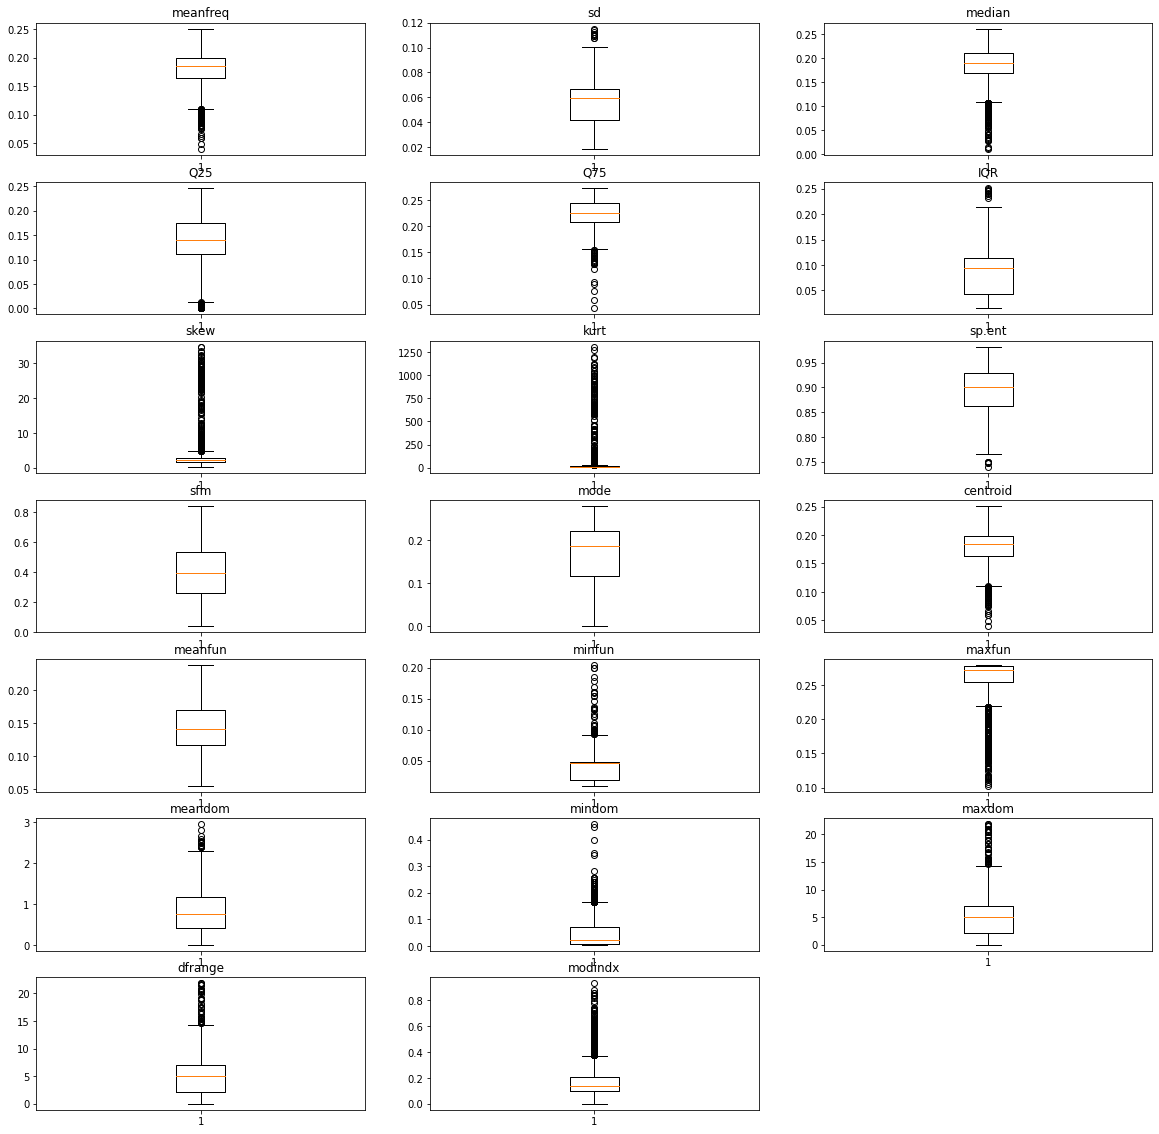

In [9]:
plt.figure(figsize=(20,20))
for i,col in enumerate(data.columns[:-1]):
  plt.subplot(7,3,i+1)
  plt.boxplot(data[col],whis=1.5)
  plt.title(col)

There are outliers in maxfun,modindx,kurt and skew

understanding the distribution of the features in the data

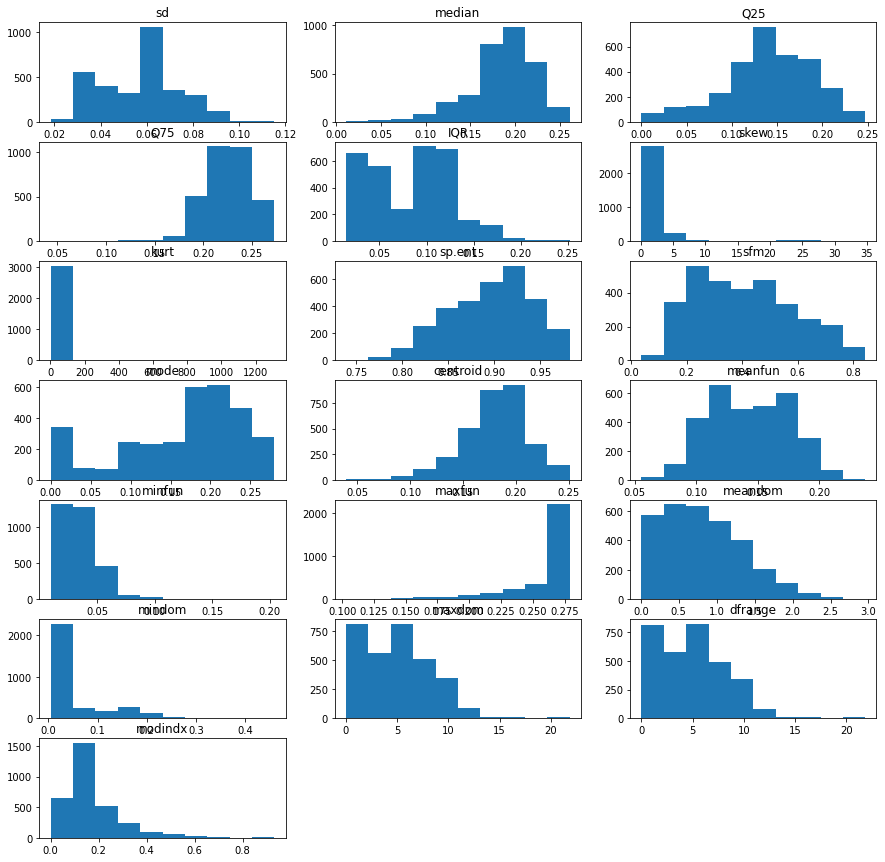

In [10]:
plt.figure(figsize=(15,15))
for i,col in enumerate(data.columns[1:20]):
  his=plt.subplot(7,3,i+1)
  plt.hist(data[col])
  plt.title(col)

None of the features follows normal distribution


Box-plots of each feature by gender (male/female) 

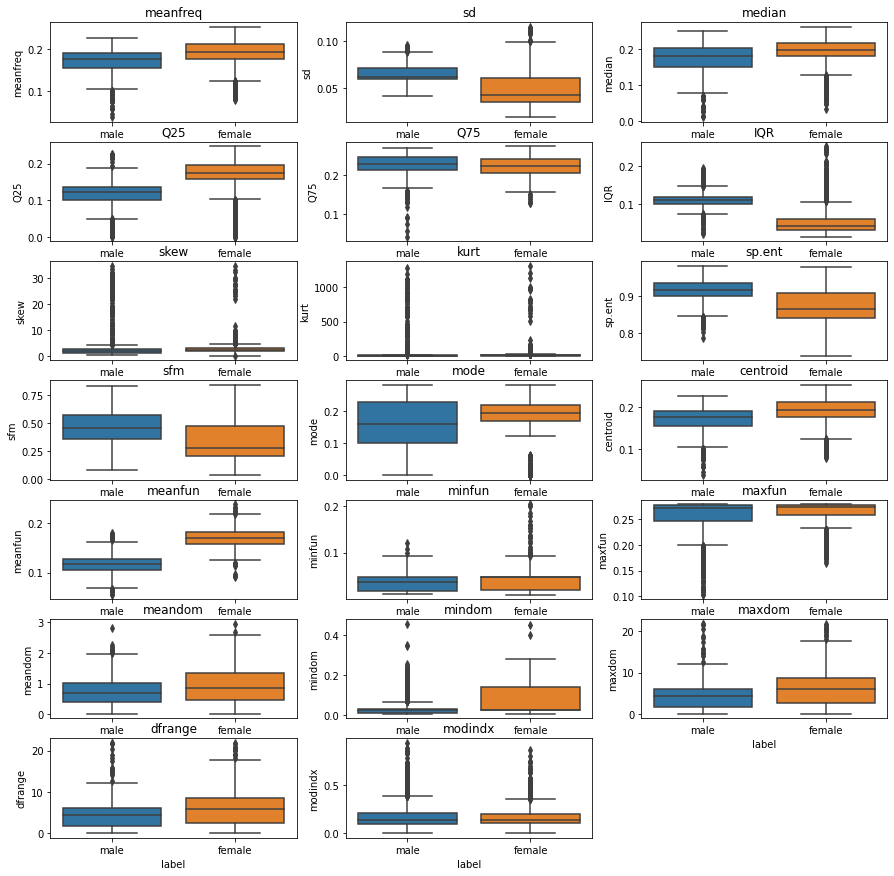

In [11]:
plt.figure(figsize=(15,15))
for i,col in enumerate(data.columns[:-1]):
  plt.subplot(7,3,i+1)
  sns.boxplot(x=data['label'],y=data[col])
  plt.title(col)

finding the distribution of target variable

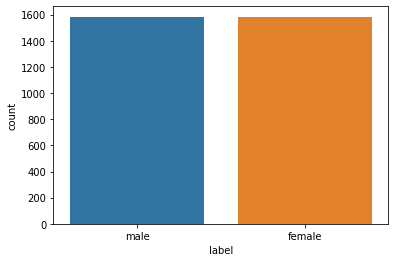

In [12]:
sns.countplot(data['label'])

Target variable has  balanced data

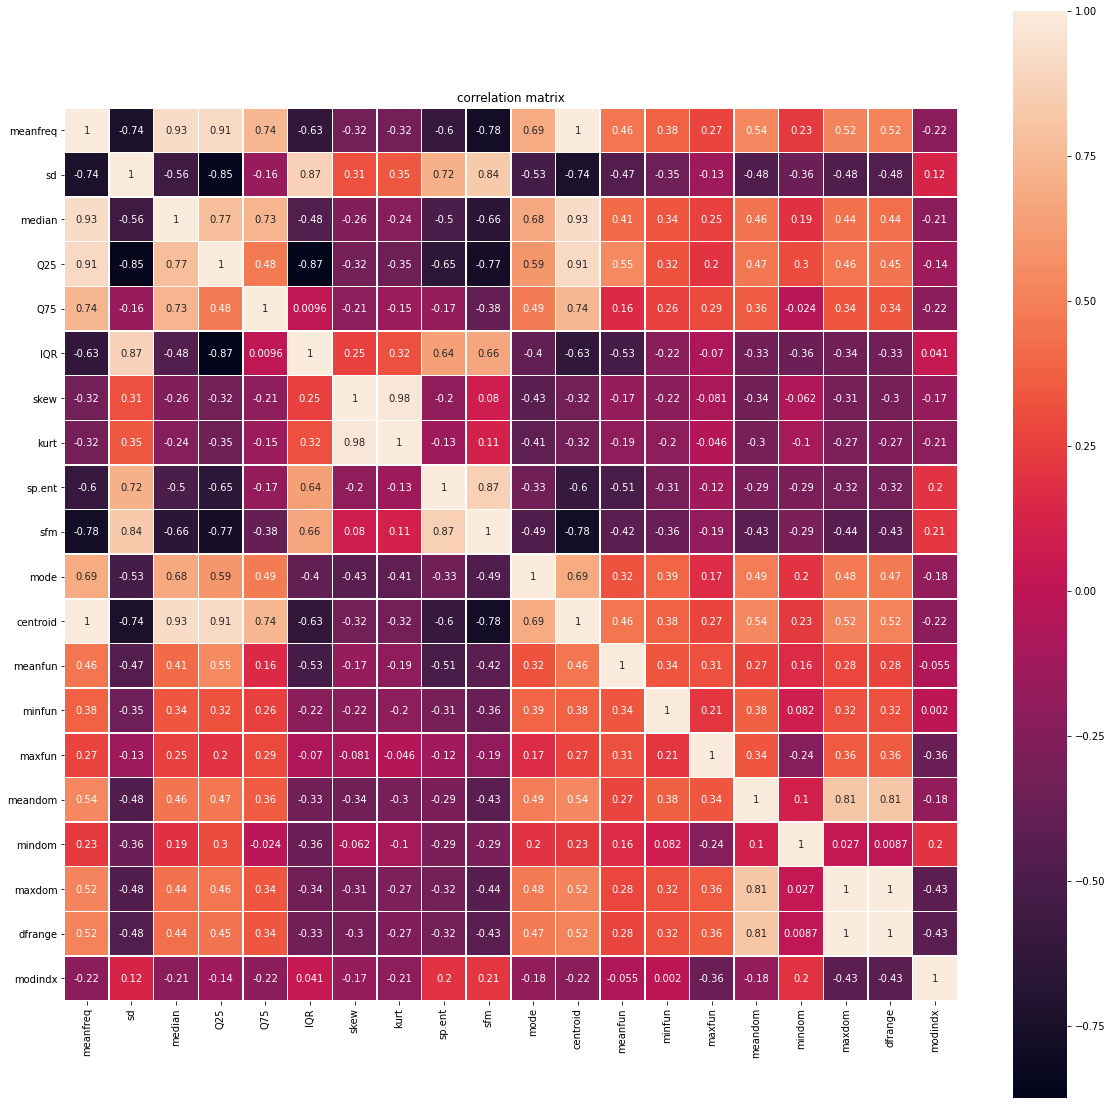

In [13]:
corrmat=data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmat,square=True,annot=True,linewidths=0.5)
plt.title("correlation matrix")

plt.show()

Plotting some of the highly correlated variables

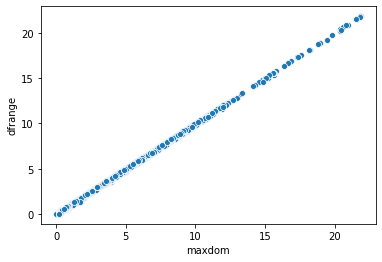

In [14]:
sns.scatterplot(x=data['maxdom'],y=data['dfrange'])

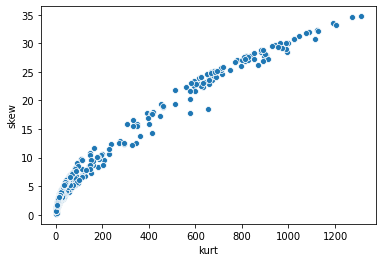

In [15]:
sns.scatterplot(x=data['kurt'],y=data['skew'])

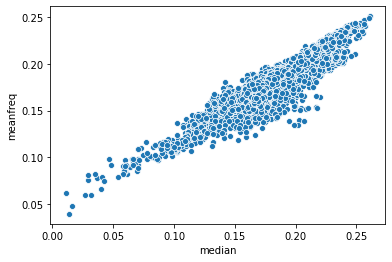

In [16]:
sns.scatterplot(x=data['median'],y=data['meanfreq'])

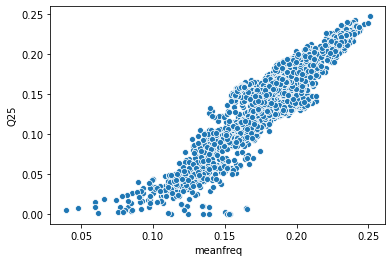

In [17]:
sns.scatterplot(x=data['meanfreq'],y=data['Q25'])

Feature Engineering

1.kurt and skew has strong correlation 

2.dfrange and maxdom has strong correlation 

3 sd,sfm has strong correlation

4.SD and IQR has strong correlation

5.Q25 and meanfreq has strong correlation

Dropping the highly correlated variables

In [18]:
data=data.drop(['kurt','maxdom','skew','median','Q25','sfm','sd'],axis=1)

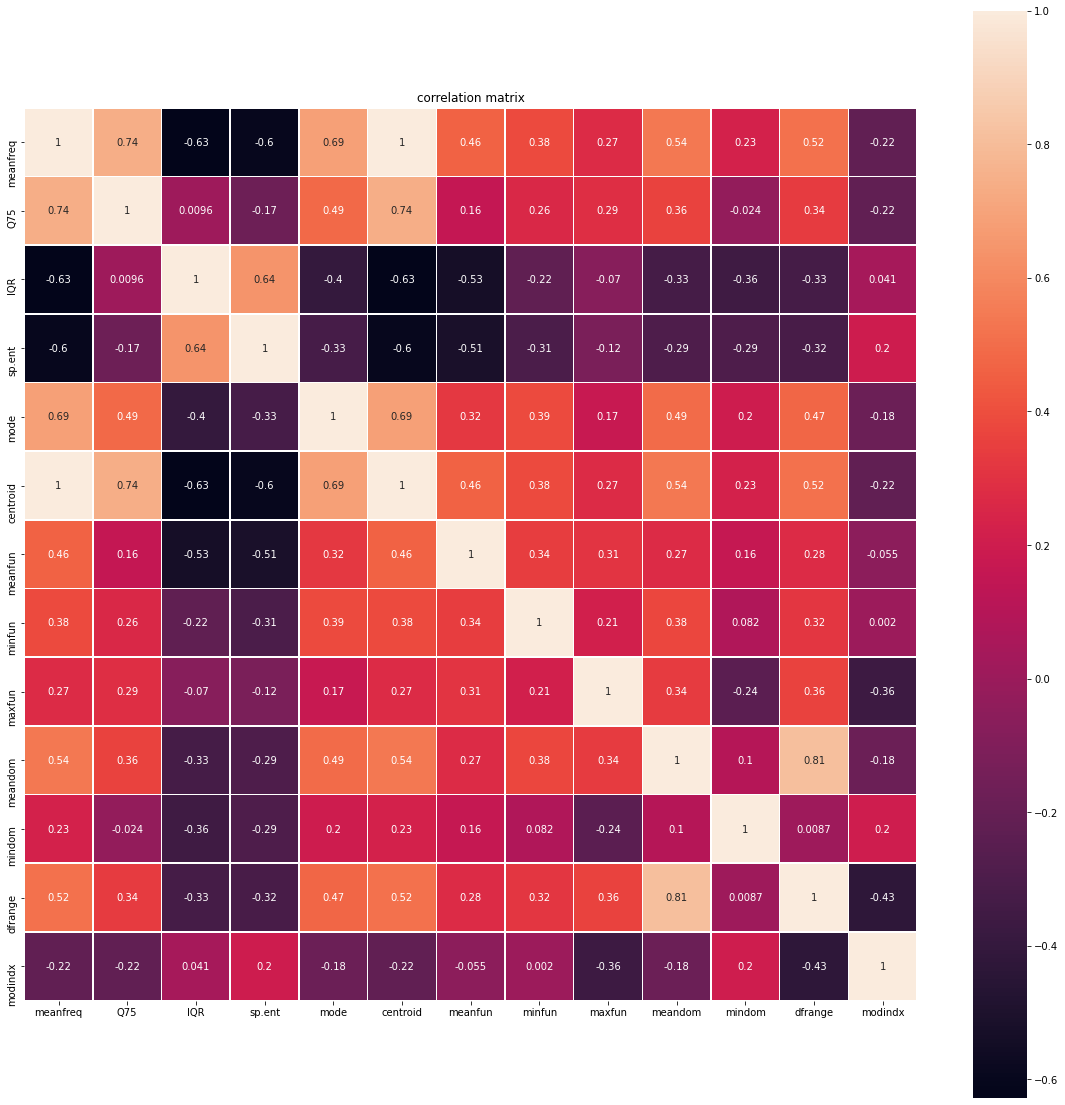

In [19]:
corrmat=data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmat,square=True,annot=True,linewidths=0.5)
plt.title("correlation matrix")

plt.show()

Standardizing the data and converting target variable which is continous into discrete

In [20]:
x=data.drop('label',axis=1)
sc=StandardScaler()
x_sc=sc.fit_transform(x)
y=data['label']
y_d=pd.get_dummies(y)

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=19)

Logistic Regression Model

In [21]:
lr= LogisticRegression(solver='lbfgs',max_iter=500,random_state=2)
lr.fit(x_train,y_train)
y_pred_lr=lr.predict(x_test)
print("Accuracy of Logistic Regression model is:",accuracy_score(y_pred_lr,y_test))

Accuracy of Logistic Regression model is: 0.8911671924290221


K nearest neighbor

In [22]:
knn=KNeighborsClassifier(n_neighbors=4)
knn.fit(x_train,y_train)
y_pred_knn=knn.predict(x_test)
print("Accuracy of k nearest neighbor model is:",accuracy_score(y_pred_knn,y_test))

Accuracy of k nearest neighbor model is: 0.7949526813880127


Support Vector Classification

In [23]:
svc=SVC(C=20,kernel='linear')
svc.fit(x_train,y_train)
y_pred_svc=svc.predict(x_test)
print("Accuracy of support vector classifier model is:",accuracy_score(y_pred_svc,y_test))

Accuracy of support vector classifier model is: 0.9716088328075709


Random Forest Model

In [24]:
rf=RandomForestClassifier(n_estimators=500,max_depth=4,random_state=143)
rf.fit(x_train,y_train)
y_pred_rf=rf.predict(x_test)
print("Accuracy of Random Forest Classification model is:",accuracy_score(y_pred_rf,y_test))

Accuracy of Random Forest Classification model is: 0.9716088328075709


XGBOOST

In [25]:
boost_model= xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(x_train, y_train)
y_pred_xg = boost_model.predict(x_test)
print("Accuracy of XG boosting model is:",accuracy_score(y_pred_xg,y_test))

Accuracy of XG boosting model is: 0.9747634069400631


Among all The models XGBOOST  has the highest accuracy score

identifying the feature that contributes most to the target variable

In [26]:
predictions = rf.predict(x_test)

confusion = confusion_matrix(y_test, predictions)

In [27]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

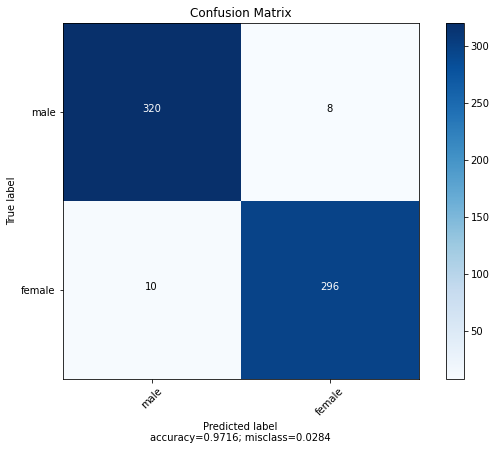

In [28]:
plot_confusion_matrix(cm=confusion, target_names = ['male', 'female'], title = 'Confusion Matrix',normalize=False)


Feature importance,

In [29]:
clf = RandomForestClassifier(random_state=0, n_jobs=-1) 
model = clf.fit(x_train, y_train) 
importances = model.feature_importances_

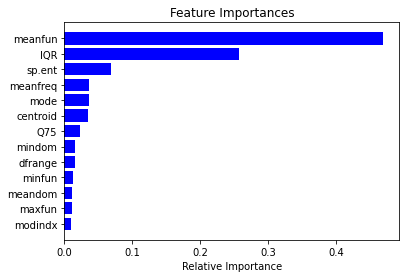

In [30]:
features = x_train.columns 
importances = model.feature_importances_ 
indices = np.argsort(importances)
plt.title('Feature Importances') 
plt.barh(range(len(indices)), importances[indices], color='b', align='center') 
plt.yticks(range(len(indices)), [features[i] for i in indices]) 
plt.xlabel('Relative Importance') 
plt.show()


meanfun has got the most importance among all other features